# Cuidado! Lluvia de Hamburguesas: 

## Análisis con Boosting


### Integrantes
* Primerano Lomba, Franco Alejandro
* Montecalvo, Ignacio

## Boosting

Este analisis lo haremos utilizando un ensable de tipo Boosting, especificamente usando el Gradient Boosting de SkLearn.
Este tipo de ensamle utiliza como modelo base árboles y se caracteriza por el hecho de que se asignan pesos de modo tal que se les otorga mayor importancia a las instancias clasificadas incorrectamente y ésto es tenido en cuenta por los siguientes árboles. Es decir, cada uno de los árboles cuenta con la información de qué tan precizas fueron las predicciones anteriores e intenta mejorar las malas predicciones.

Los hiperparametros que vamos a definir son:

* n_estimator: Es la cantidad de árboles que se utilizarán en el ensamble. Un numero muy alto podria provocar overfitting de acuerdo al learning rate utilizado, para evitarlo, resulta conveniente un n_estimator alto y un learning rate bajo.
* learning_rate: Permite controlar que tan rapido aprende el modelo. Vamos a probar con valores bajos, ya que como dijimos antes, si el learning rate es muy alto puede ocasionar overfitting. Aparece un trade off entre el n_estimator y el learning rate donde cuanto menor sea el learning rate mayor arboles necesitaremos para obtener un buen resultado.
* loss: Es la función de pérdida a optimizar. Probamos con 'deviance' y 'exponential'

### Configuraciones iniciales

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, auc, roc_curve, accuracy_score,recall_score, precision_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier

from preprocessing import agregar_feature_estacion
from preprocessing import aplicarOneHot
from preprocessing import filtrar_features_por_varianza
from preprocessing import estandarizar

from auxiliares import obtener_training_set
from auxiliares import obtener_valdev_set
from auxiliares import obtener_prediccion_set
from auxiliares import obtener_holdout_set
from auxiliares import plot_confusion_matrix
from auxiliares import plot_roc
from auxiliares import crear_archivo_predicciones

Primero cargamos los datos de entrenamiento con los missings ya resueltos.

In [2]:
x,y = obtener_training_set()

### Preprocesamiento

#### Manejo de Missing Values
El manejo de los Missing Values se realiza usando la misma lógica que en la primera parte del TP. De todas formas, ya importamos el dataset de entrenamiento con los missings solucionados

#### Agregado de feature 'Estacion'

In [3]:
x1 = agregar_feature_estacion(x)

#### One Hot Encoding
Aplicamos One-hot encoding a los features categóricos:

In [4]:
x1 = aplicarOneHot(x)

### Otro Preprocesamiento

Vamos a aplicar reducción de dimensionalidad seleccionando las features por varianza, usando el VarianceThreshold de SkLearn. No aplicamos One Hot Encoding debido a que solo nos quedamos con features numéricos

In [5]:
x2 = filtrar_features_por_varianza(x,x,25)

In [6]:
print("* Features antes de reducción: ", len(x.columns),"\n* Features después de reducción: ", len(x2.columns))

* Features antes de reducción:  26 
* Features después de reducción:  12


### Selección de Hiperparámetros

#### Probamos con el primer preprocesamiento (feature 'Estacion' + OHE)

Primero vamos a comenzar haciendo Grid Search con un numero de estimadores fijo. En este caso buscamos un numero alto, por lo que decidimos probar con 500. A su vez, vamos a probar con posibles learning rate bajos: 0.01 y 0.1.  
Hacemos esto debido a que cuanto mayor es la cantidad de estimadores, el tiempo que tarda en realizarse el Grid Search aumenta significativamente por eso tratamos este caso por separado y con menos parámetros posibles.

In [7]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=119)

boosting_clasificador = GradientBoostingClassifier(n_estimators=500)
parametros =  {'loss': ['deviance', 'exponential'],'learning_rate': [0.01,0.1]}
gs_boosting = GridSearchCV(boosting_clasificador, parametros, n_jobs = -1, cv = kf, scoring ='roc_auc')
gs_boosting.fit(x1, y.llovieron_hamburguesas_al_dia_siguiente)
    

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=GradientBoostingClassifier(n_estimators=500), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'loss': ['deviance', 'exponential']},
             scoring='roc_auc')

In [8]:
resultados = pd.DataFrame(gs_boosting.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_loss','param_learning_rate','mean_test_score','std_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_loss,param_learning_rate,mean_test_score,std_test_score,mean_score_time
3,1,exponential,0.100000,0.887541,0.003717,0.272899
2,2,deviance,0.100000,0.887181,0.003904,0.304162
1,3,exponential,0.010000,0.867439,0.004315,0.682875
0,4,deviance,0.010000,0.866841,0.004348,0.689742


Vemos que la media de los AUC Score obtenidos fue relativamente alta, ahora probamos con menos estimadores pero con cantidades más variadas de learning rates.

In [9]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=119)
    
boosting_clasificador_2 = GradientBoostingClassifier()
parametros_2 =  {'loss': ['deviance', 'exponential'], 'n_estimators':[10, 30, 50, 100],'learning_rate': [0.01, 0.1, 1, 2]}
gs_boosting_2 = GridSearchCV(boosting_clasificador_2, parametros_2, n_jobs = -1, cv = kf, scoring ='roc_auc')
gs_boosting_2.fit(x1, y.llovieron_hamburguesas_al_dia_siguiente)
    

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 1, 2],
                         'loss': ['deviance', 'exponential'],
                         'n_estimators': [10, 30, 50, 100]},
             scoring='roc_auc')

In [10]:
resultados = pd.DataFrame(gs_boosting_2.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_loss','param_learning_rate','param_n_estimators','mean_test_score','std_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_loss,param_learning_rate,param_n_estimators,mean_test_score,std_test_score,mean_score_time
23,1,exponential,1,100,0.879315,0.002502,0.155209
22,2,exponential,1,50,0.877621,0.002781,0.112163
15,3,exponential,0.100000,100,0.874615,0.003852,0.149662
11,4,deviance,0.100000,100,0.874100,0.003716,0.274769
19,5,deviance,1,100,0.874054,0.004559,0.149967


Efectivamente, el que obtuvo el score mas alto fue el que tenia n_estimators = 100 por lo que en principio parece que debemos buscar una alta cantidad de estimadores acompañado de un learning rate correcto, de manera que la función de pérdida no resulta tan relevante en cuanto a variaciones en el score. Entonces, nos quedamos con el mejor modelo de la primera prueba, que posee 500 estimadores.

#### Probamos con el primer preprocesamiento pero estandarizando

In [12]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=119)

boosting_clasificador_3 = GradientBoostingClassifier(n_estimators=500)
parametros_3 =  {'loss': ['deviance', 'exponential'],'learning_rate': [0.01,0.1]}
gs_boosting_3 = GridSearchCV(boosting_clasificador_3, parametros_3, n_jobs = -1, cv = kf, scoring ='roc_auc')
gs_boosting_3.fit(estandarizar(pd.DataFrame(x1.copy()),pd.DataFrame(x1.copy())), y.llovieron_hamburguesas_al_dia_siguiente)
    

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=GradientBoostingClassifier(n_estimators=500), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'loss': ['deviance', 'exponential']},
             scoring='roc_auc')

In [13]:
resultados = pd.DataFrame(gs_boosting_3.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_loss','param_learning_rate','mean_test_score','std_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_loss,param_learning_rate,mean_test_score,std_test_score,mean_score_time
3,1,exponential,0.100000,0.887526,0.003693,0.423910
2,2,deviance,0.100000,0.887192,0.003940,0.478088
1,3,exponential,0.010000,0.867436,0.004312,0.418310
0,4,deviance,0.010000,0.866840,0.004349,0.490712


#### Probamos con el segundo preprocesamiento (Selección de features por varianza)

Vamos a probarlo directamente con n_estimator = 500 que fue el que mejor resultado nos dio antes, y probamos para distintas funciones de pérdida y distintos learning rates.

In [14]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=119)

boosting_clasificador_4 = GradientBoostingClassifier(n_estimators=500)
parametros_4 =  {'loss': ['deviance', 'exponential'],'learning_rate': [0.01,0.1]}
gs_boosting_4 = GridSearchCV(boosting_clasificador_4, parametros, n_jobs = -1, cv = kf, scoring ='roc_auc')
gs_boosting_4.fit(x2, y.llovieron_hamburguesas_al_dia_siguiente)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=119, shuffle=True),
             estimator=GradientBoostingClassifier(n_estimators=500), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'loss': ['deviance', 'exponential']},
             scoring='roc_auc')

In [15]:
resultados = pd.DataFrame(gs_boosting_4.cv_results_)
resultados = resultados[resultados.rank_test_score <= 5].sort_values(by='rank_test_score', ascending=True)
resultados = resultados[['rank_test_score','param_loss','param_learning_rate','mean_test_score','std_test_score','mean_score_time' ]].style.apply(
            lambda x: ['background: lightgreen' if (x.rank_test_score == 1) else '' for i in x], axis=1)
resultados

,rank_test_score,param_loss,param_learning_rate,mean_test_score,std_test_score,mean_score_time
2,1,deviance,0.100000,0.865359,0.003605,0.168887
3,2,exponential,0.100000,0.865341,0.003492,0.157234
1,3,exponential,0.010000,0.854213,0.003829,0.203123
0,4,deviance,0.010000,0.853721,0.004047,0.219830


#### Resultados

Si bien el score obtenido al aplicar selección de features sigue siendo bastante aceptable considerando que reducimos a más de la mitad nuestra dimensionalidad, el score para el primer preprocesamiento es bastante superior. Por lo tanto, nos quedamos con el primer preprocesamiento sin estandarizar los datos y usamos como mejor modelo el que posee los 500 estimadores.

### Entrenamiento y evaluación del modelo

In [17]:
boosting_clasificador = gs_boosting.best_estimator_
boosting_clasificador.fit(x1, y.llovieron_hamburguesas_al_dia_siguiente)

GradientBoostingClassifier(loss='exponential', n_estimators=500)

#### Vemos qué pasa con los datos de entrenamiento

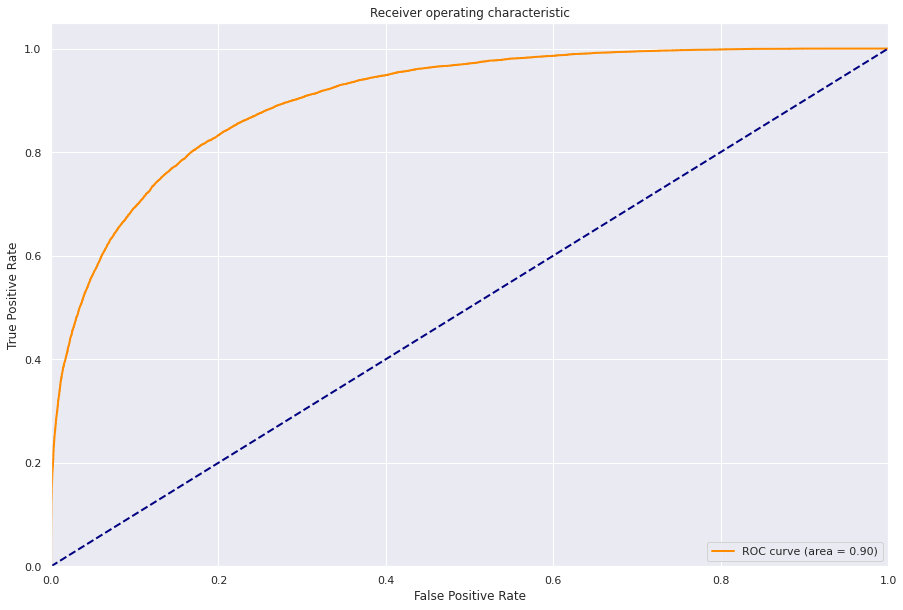

AUC ROC SCORE:  0.9035895227342666


In [61]:
predicciones_training = boosting_clasificador.predict_proba(x1)

fpr, tpr, thresholds = roc_curve(y, predicciones_training[:, 1], pos_label="si")
plot_roc(fpr, tpr, thresholds)
auc = roc_auc_score(y, predicciones_training[:, 1])
print("AUC ROC SCORE: ",auc)

Como es de esperarse, para los datos de entrenamiento (datos ya vistos y conocidos) el AUC es bastante elevado, veamos qué sucede con los datos de valdev

#### Evaluación sobre valdev

Ahora cargamos el set de datos con el que vamos a evaluar:

In [18]:
x_val, y_val = obtener_valdev_set() 

Aplicamos toda la lógica de preprocesamiento sobre estos datos de testing.

In [19]:
# Relleno de missing values -> Dataset cargado con missing values ya tratados

# Agregamos feature de estacion
x_val = agregar_feature_estacion(x_val)

# One Hot Encoding
x_val = aplicarOneHot(x_val)

In [41]:
predicciones_proba = boosting_clasificador.predict_proba(x_val)
predicciones = boosting_clasificador.predict(x_val)

### Scores

#### AUC ROC



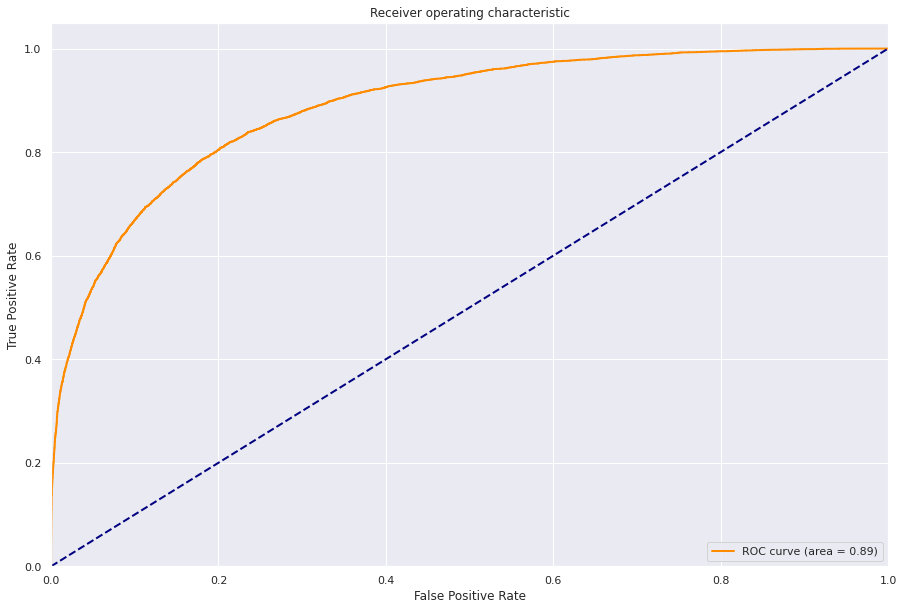

AUC ROC SCORE:  0.887294035885763


In [42]:
fpr, tpr, thresholds = roc_curve(y_val, predicciones_proba[:, 1], pos_label="si")
plot_roc(fpr, tpr, thresholds)
auc = roc_auc_score(y_val, predicciones_proba[:, 1])
print("AUC ROC SCORE: ",auc)

Como es de esperarse, el AUC score es inferior para los datos de validación respecto de los de entrenamiento, igualmente se mantiene bastante alto

#### Matriz de confusión



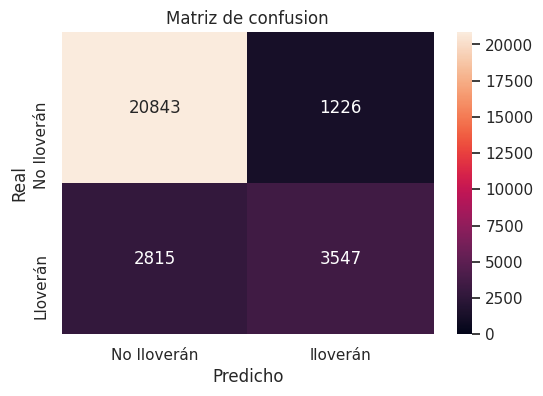

In [43]:
plot_confusion_matrix(y_val, predicciones)

#### Accuracy

In [44]:
accuracy = accuracy_score(y_val,predicciones)
print("ACCURACY SCORE: ",accuracy)

ACCURACY SCORE:  0.857866413421969


#### Precision y Recall 



In [45]:
precision = precision_score(y_val.llovieron_hamburguesas_al_dia_siguiente,predicciones, pos_label='si')
recall = recall_score(y_val.llovieron_hamburguesas_al_dia_siguiente,predicciones, pos_label='si')

print("PRECISION: ",precision,"\nRECALL: ",recall)

PRECISION:  0.7431384873245338 
RECALL:  0.5575290789060044


#### F1 Score

In [46]:
f1 = f1_score(y_val, predicciones, pos_label='si')
print("F1 SCORE: ", f1_score)

F1 SCORE:  <function f1_score at 0x7f2251fe3ca0>


In [47]:
pd.DataFrame(data=[auc, accuracy, precision,recall,f1],
             index= ['AUC ROC','Accuracy','Precision','Recall','F1 Score'],
             columns=['KNN Scores'])

,KNN Scores
AUC ROC,0.887294
Accuracy,0.857866
Precision,0.743138
Recall,0.557529
F1 Score,0.637090


#### Algunas observaciones

* El AUC ROC es superior al resto de los modelos tomados, por lo que consideramos que es bastante decente. 

* El Accuracy también es mayor al que obtuvimos con el resto de los modelos (y también el baseline del TP 1)

* Los valores de Precision y Recall son relativamente bajos (aunque también superan a los anteriores modelos) pero creemos que esto se debe al desbalance que hay en el dataset donde predomina en el target la clase 'no' por lo que el modelo tiende a predecir más veces 'no' que 'si', y ante una cantidad pequeña de True Positives, tanto Precision como Recall son más suceptibles a errores (sea FP o FN respectivamente)


## Predicción sobre Hold out

Como fue el modelo que obtuvo el mayor AUC score, es el modelo con el cual realizaremos las predicciones sobre los datos del set Hold out para ver cómo se comporta el modelo con estos datos nunca antes vistos (tanto por el modelo como por nosotros mismos)

Ahora cargamos el Hold out set:

In [48]:
x_holdout, y_holdout = obtener_holdout_set() 

Aplicamos toda la lógica de preprocesamiento sobre estos datos de holdout.

In [49]:
# Relleno de missing values -> Dataset cargado con missing values ya tratados

# Agregamos feature de estacion
x_holdout = agregar_feature_estacion(x_holdout)

# One Hot Encoding
x_holdout = aplicarOneHot(x_holdout)

In [50]:
predicciones_proba_holdout = boosting_clasificador.predict_proba(x_holdout)
predicciones_holdout = boosting_clasificador.predict(x_holdout)

### Scores

#### AUC ROC



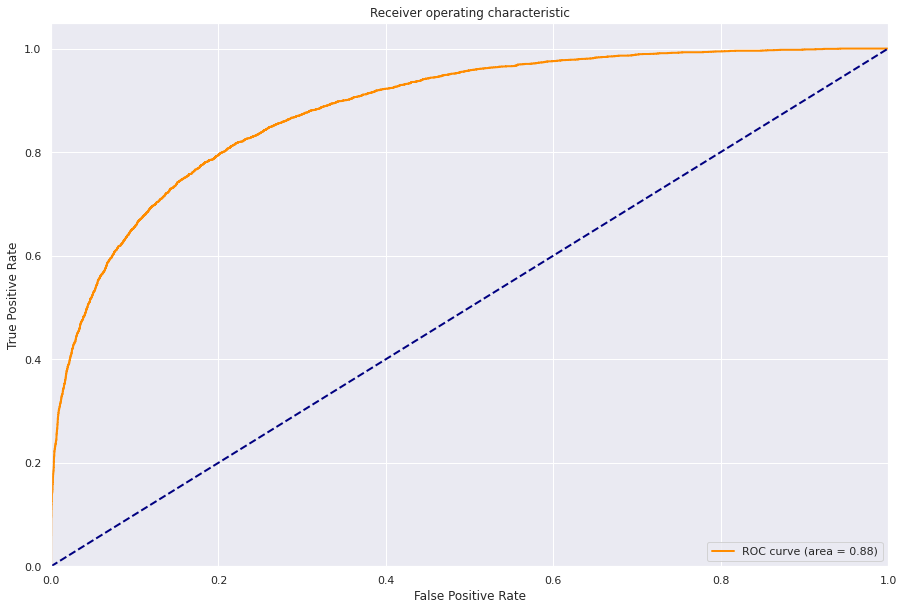

AUC ROC SCORE:  0.8843731581438045


In [51]:
fpr, tpr, thresholds = roc_curve(y_holdout, predicciones_proba_holdout[:, 1], pos_label="si")
plot_roc(fpr, tpr, thresholds)
auc_holdout = roc_auc_score(y_holdout, predicciones_proba_holdout[:, 1])
print("AUC ROC SCORE: ",auc_holdout)

Vemos que para el holdout el AUC es el más bajo de todos, lo cual tiene sentido ya que son los datos que hasta entonces resultan desconocidos completamente

#### Matriz de confusión



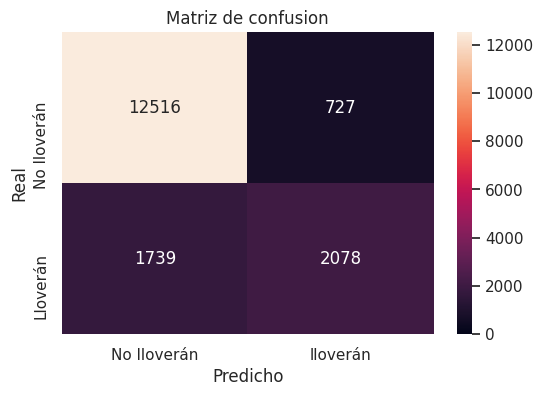

In [52]:
plot_confusion_matrix(y_holdout, predicciones_holdout)

#### Accuracy

In [53]:
accuracy_holdout = accuracy_score(y_holdout,predicciones_holdout)
print("ACCURACY SCORE: ",accuracy_holdout)

ACCURACY SCORE:  0.8554513481828839


#### Precision y Recall 



In [54]:
precision_holdout = precision_score(y_holdout.llovieron_hamburguesas_al_dia_siguiente,predicciones_holdout, pos_label='si')
recall_holdout = recall_score(y_holdout.llovieron_hamburguesas_al_dia_siguiente,predicciones_holdout, pos_label='si')

print("PRECISION: ",precision_holdout,"\nRECALL: ",recall_holdout)

PRECISION:  0.7408199643493761 
RECALL:  0.5444066020434897


#### F1 Score

In [55]:
f1_holdout = f1_score(y_holdout, predicciones_holdout, pos_label='si')
print("F1 SCORE: ", f1_holdout)

F1 SCORE:  0.6276049531863486


In [56]:
pd.DataFrame(data=[auc_holdout, accuracy_holdout, precision_holdout,recall_holdout,f1_holdout],
             index= ['AUC ROC','Accuracy','Precision','Recall','F1 Score'],
             columns=['KNN Scores'])

,KNN Scores
AUC ROC,0.884373
Accuracy,0.855451
Precision,0.740820
Recall,0.544407
F1 Score,0.627605


### Comparación con versión anterior del TP

En la versión anterior, obtuvimos un AUC score del holdout que superaba al AUC score obtenido para los datos de entrenamiento y para los de valdev.
* En el caso de los datos de entrenamiento, lo que sucedía es que comparábamos el AUC score sobre el holdout contra el promedio del AUC score de los k-folds (5), pero vemos que si usamos la totalidad de los datos de entrenamiento para hacer la predicción, este último resulta bastante superior al del holdout lo cual es esperable, pues son los datos usados para entrenar al modelo, y por lo tanto son conocidos.

* En el caso de los datos de valdev, efectivamente AUC score sí era superior al del holdout. Sin embargo, cambiando la seed al momento de particionar los datos (seed anterior: 119, seed actual: 50) y dandole un 5% más de datos al holdout (proporción anterior: 10%, proporción actual: 15%) obtuvimos un resultado más realista donde el AUC score del holdout es inferior al del valdev, tal como se pudo observar anteriormente. A continuación dejamos los AUC score y la curva ROC con el split viejo para hacer más visible esta comparación.

In [63]:
x_train_viejo = pd.read_csv("Datasets/Datasets version anterior/training_features.csv")
y_train_viejo = pd.read_csv("Datasets/Datasets version anterior/training_target.csv")

x_valdev_viejo = pd.read_csv("Datasets/Datasets version anterior/valdev_features.csv")
y_valdev_viejo = pd.read_csv("Datasets/Datasets version anterior/valdev_target.csv")

x_holdout_viejo = pd.read_csv("Datasets/Datasets version anterior/holdout_features.csv")
y_holdout_viejo = pd.read_csv("Datasets/Datasets version anterior/holdout_target.csv")

In [64]:
# Preprocesamos
x_train_viejo = agregar_feature_estacion(x_train_viejo)
x_train_viejo = aplicarOneHot(x_train_viejo)

x_valdev_viejo = agregar_feature_estacion(x_valdev_viejo)
x_valdev_viejo = aplicarOneHot(x_valdev_viejo)

x_holdout_viejo = agregar_feature_estacion(x_holdout_viejo)
x_holdout_viejo = aplicarOneHot(x_holdout_viejo)

In [68]:
boosting_clasificador.fit(x_train_viejo,y_train_viejo.llovieron_hamburguesas_al_dia_siguiente)

GradientBoostingClassifier(loss='exponential', n_estimators=500)

In [69]:
predicciones_valdev_viejo_proba = boosting_clasificador.predict_proba(x_valdev_viejo)
predicciones_holdout_viejo_proba = boosting_clasificador.predict_proba(x_holdout_viejo)

#### AUC SCORE VALDEV anterior

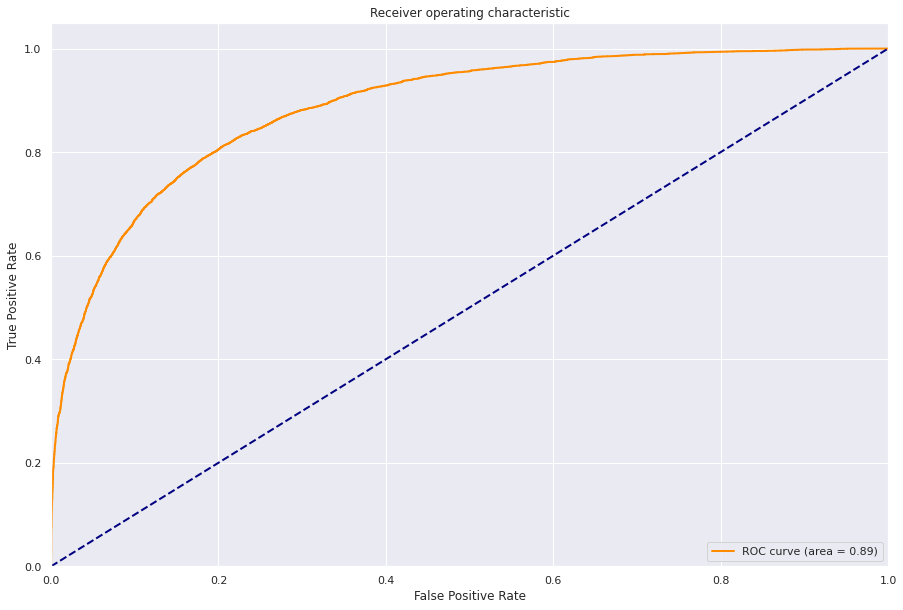

VALDEV AUC ROC SCORE:  0.8874738958020315


In [74]:
fpr, tpr, thresholds = roc_curve(y_valdev_viejo, predicciones_valdev_viejo_proba[:, 1], pos_label="si")
plot_roc(fpr, tpr, thresholds)
auc_valdev_viejo = roc_auc_score(y_valdev_viejo, predicciones_valdev_viejo_proba[:, 1])
print("VALDEV AUC ROC SCORE: ",auc_valdev_viejo)

#### AUC SCORE HOLDOUT anterior

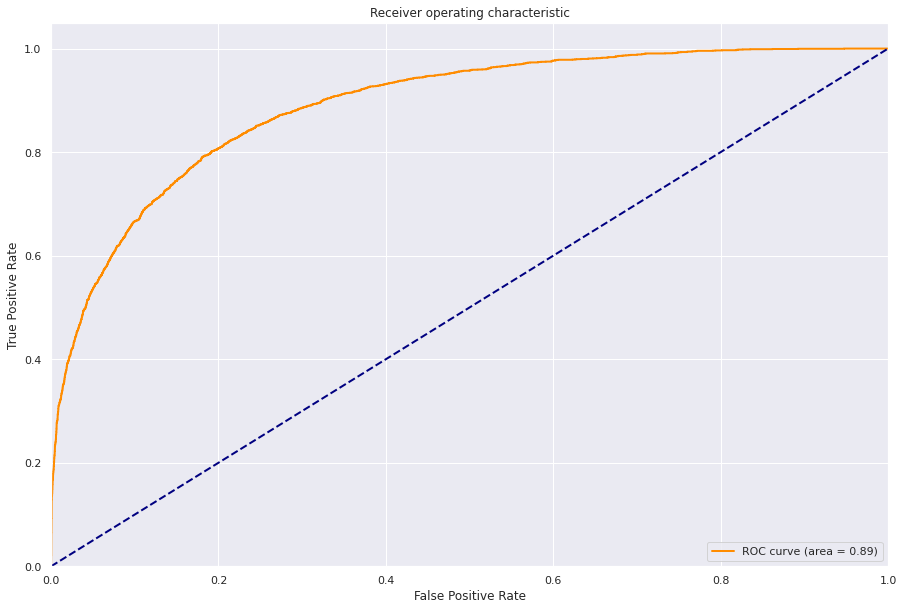

HOLDOUT AUC ROC SCORE:  0.8891215039128046


In [75]:
fpr, tpr, thresholds = roc_curve(y_holdout_viejo, predicciones_holdout_viejo_proba[:, 1], pos_label="si")
plot_roc(fpr, tpr, thresholds)
auc_holdout_viejo = roc_auc_score(y_holdout_viejo, predicciones_holdout_viejo_proba[:, 1])
print("HOLDOUT AUC ROC SCORE: ",auc_holdout_viejo)

En estos dos scores podemos visualizar lo comentado durante la comparación, con la anterior partición de datos el AUC score para el holdout (0.8891) era superior al del valdev (0.8874). Mientras que para la partición actual, el AUC score para el holdout (0.8843) es inferior al del valdev (0.8873). Notar que los dos AUC score sobre los valdev se mantienen muy similares en ambas particiones.

## Predicción sobre el nuevo dataset

Realizamos la predicción sobre el nuevo dataset utilizando el preprocesamiento aplicado anteriormente

In [57]:
nuevo_ds = obtener_prediccion_set()
ids_registro = np.array(nuevo_ds['id'])
nuevo_ds.drop('id', inplace=True, axis=1)

# Relleno de missing values -> Dataset cargado con missing values ya tratados

# Agregamos feature de estacion
x_nuevo = agregar_feature_estacion(nuevo_ds)

# One Hot Encoding
x_nuevo = aplicarOneHot(x_nuevo)

predicciones = boosting_clasificador.predict(x_nuevo)
crear_archivo_predicciones(predicciones,"Boosting",ids_registro)